The competition "House Prices - Advanced Regression Techniques" from Kaggle <br>https://www.kaggle.com/c/house-prices-advanced-regression-techniques
<br>Predict sales prices and practice feature engineering, RFs, and gradient boosting

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.stats import skew
from scipy.special import boxcox1p
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn import metrics

from sklearn import utils
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import ShuffleSplit

from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.stats import skew
from scipy.special import boxcox1p

from sklearn.svm import SVR
from sklearn.svm import LinearSVR

from sklearn.neural_network import MLPRegressor

from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

sns.set_style('darkgrid')

def plot_correlation(X, y):
    correlation_analyse = pd.concat([X, y], axis=1)
    corrmatrix = correlation_analyse.corr().drop(['SalePrice'])
    corrs = corrmatrix['SalePrice'].sort_values(ascending=False)

    f, ax = plt.subplots(ncols=2, figsize=(10, 5))
    sns.barplot(x=corrs[:25].index, y=corrs[:25], ax=ax[0], color='gray')
    f.suptitle('Correlation with Target')
    ax[0].tick_params(rotation=90)
    sns.barplot(x=corrs[-25:].index, y=corrs[-25:], ax=ax[1], color='gray')
    ax[1].tick_params(rotation=90)
    return corrs

def missed_values_barplot(data):
    missed_values = {}
    for column in data.columns:
        missed_values[column] = np.sum(data[column].isna())
    missed_values_pd = pd.Series(data=missed_values)
    missed_values_pd.sort_values(ascending=False, inplace=True)
    sns.barplot(x=missed_values_pd.index[:25], y=missed_values_pd[:25], color='gray')
    plt.tick_params(rotation=90)
    

def RMSLE(y_predicted, labels):
    if len(y_predicted) != len(labels):
        return -1
    return np.sqrt(np.mean(np.square(np.log1p(y_predicted) - np.log1p(labels))))
rmsle = make_scorer(RMSLE, greater_is_better=False)


def filling_NA(data, column_list, value=None, mode_flag=False):
    if mode_flag == True:
        for column in column_list:
            data[column].fillna(data[column].mode()[0], inplace=True)
    else:
        for column in column_list:
            data[column].fillna(value, inplace=True)
            
def strategy_for_filling(data, columns_for_inpute):
    f, ax = plt.subplots(ncols=1, nrows=len(columns_for_inpute), figsize=(5, 7 * len(columns_for_inpute)))
    ravel_ax = np.ravel(ax)
    for index, ax in enumerate(ravel_ax):
        sns.countplot(x=columns_for_inpute[index], data=data, color='gray', ax=ax)
        for label in ax.get_xticklabels():
            label.set_rotation(90)         

def cramers_corrected_2_features(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

def cramers_corr(data, cat_features):
    cramers_correlation = pd.DataFrame(index=cat_features, columns=cat_features)
    for column_x in cat_features:
        for column_y in cat_features:
            confusion_matrix = pd.crosstab(data[column_x], data[column_y]).as_matrix()
            cramers_correlation.loc[column_x, column_y] = cramers_corrected_2_features(confusion_matrix)
    f, ax = plt.subplots(figsize=(20, 20))
    sns.heatmap(cramers_correlation.astype(float), annot=True, fmt="0.1f", ax=ax);
            
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

## Remove outliers

In [2]:
#sns.scatterplot(x=train_data['GrLivArea'], y=train_data['SalePrice'], color='gray')
drop_indexes = train_data[train_data['GrLivArea'] > 4000].index
train_data.drop(labels=drop_indexes, axis=0, inplace=True)

In [3]:
#sns.scatterplot(x=train_data['GrLivArea'], y=train_data['SalePrice'], color='gray');

In [4]:
train_data.index = range(len(train_data.index))
train_y = train_data.loc[:, "SalePrice"]
train_data = train_data.drop(["Id", "SalePrice"], axis=1)
test_ids = test_data['Id']
test_data = test_data.drop(["Id"], axis=1)

train_size = train_data.shape[0]
test_size = test_data.shape[0]
data = pd.concat([train_data, test_data], axis=0, ignore_index=True)
print('Train_data size: ', train_data.shape)
print('Label size: ', train_y.shape)
print('Test data size: ', test_data.shape)
print('All size: ', data.shape)

Train_data size:  (1456, 79)
Label size:  (1456,)
Test data size:  (1459, 79)
All size:  (2915, 79)


# Filling NAs

In [5]:
print('Number NAs before imputing: ', np.sum(np.sum(data.isna())))
none_filling_list = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 
            'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType', 'BsmtCond',
            'BsmtQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond']

zero_filling_list = ['GarageArea', 'GarageCars', 'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 
             'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']

mode_filling_list = ['Functional', 'Electrical', 'Utilities', 'SaleType', 'MSZoning',
                    'Exterior1st', 'Exterior2nd', 'KitchenQual']

filling_NA(data, column_list=none_filling_list, value='None')
filling_NA(data, column_list=zero_filling_list, value=0)
filling_NA(data, column_list=mode_filling_list, mode_flag=True)
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

print('Number NAs after imputing: ', np.sum(np.sum(data.isna())))

data_train = data.loc[:train_size - 1,:]
data_test = data.loc[train_size: ,:]
print('Train_preprocessed_size: ', data_train.shape)
print('Test_preprocessed_size: ', data_test.shape)

Number NAs before imputing:  13952
Number NAs after imputing:  0
Train_preprocessed_size:  (1456, 79)
Test_preprocessed_size:  (1459, 79)


# Poly features

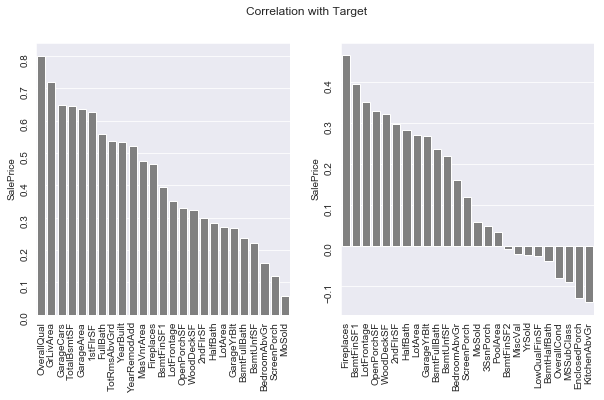

In [6]:
corrs = plot_correlation(data_train, train_y)

In [7]:
#corrs[:10]

poly_features = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
std_scaler = StandardScaler()
new_features = poly_features.fit_transform(data.loc[:, corrs[:10].index])

new_features = std_scaler.fit_transform(new_features)

pd_poly_feats = pd.DataFrame(new_features, 
                             columns=poly_features.get_feature_names()).drop(poly_features.get_feature_names()[:10], axis=1)


pd_poly_feats.shape


(2915, 55)

# Encoding categorical features

In [8]:
cat_features = []
for column in data_train.columns:
    if data_train[column].dtype == data_train['Alley'].dtype:
        cat_features.append(column)

data_labels = pd.concat([data_train, train_y], axis=1)

In [9]:
def triple_plot(feature_name, target_name, train_data_labels, train_test_data):
    print(train_test_data[feature_name].value_counts())
    sns.boxplot(x=feature_name, y=target_name, data=train_data_labels, 
                order=list(train_data_labels.groupby(by=feature_name)[target_name].median().sort_values(ascending=True).index))
    sns.catplot(x=feature_name, y=target_name, data=train_data_labels,
               order=list(train_data_labels.groupby(by=feature_name)[target_name].median().sort_values(ascending=True).index))
    sns.catplot(x=feature_name, y=target_name, kind="bar", data=train_data_labels,
               order=list(train_data_labels.groupby(by=feature_name)[target_name].median().sort_values(ascending=True).index));

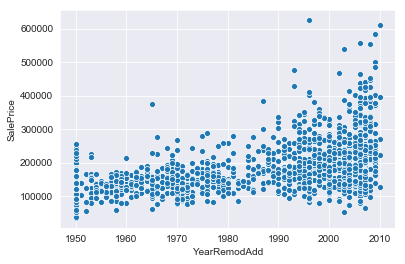

In [10]:
sns.scatterplot(x='YearRemodAdd', y='SalePrice', data=data_labels);

In [11]:
dic_BsmtQual = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'None': 0}
dic_BsmtCond = {'Gd': 4, 'TA': 3, 'Fa': 2, 'None': 1, 'Po': 0}
dic_BsmtExposure = {'Gd': 4,'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}
dic_KitchenQual = {'Ex': 3, 'Gd': 2, 'TA': 1, 'Fa': 0}
dic_FireplaceQu = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'None': 1, 'Po': 0}
dic_ExterQual = {'Ex': 3, 'Gd': 2, 'TA': 1, 'Fa': 0}
dic_HeatingQC = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}
dic_CentralAir = {'Y': 1, 'N': 0}
dic_GarageFinish = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}

# cluster values in one class
dic_HouseStyle = {'1.5Fin': '1.5Story', '1.5Unf': '1.5Story', '2.5Unf': '2.5Story', '2.5Fin': '2.5Story'}
dic_GarageQual = {'Po': 'Low', 'Fa': 'Low', 
                  'Ex': 'High', 'Gd': 'High'}
dic_GarageCond = {'Po': 'Low', 'Fa': 'Low', 
                  'Ex': 'High', 'Gd': 'High'}
dic_Condition1 = {'PosA': 'Pos', 'PosN': 'Pos', 
                  'Artery': 'Street', 'Feedr': 'Street',
                  'RRNe': 'Train', 'RRNn': 'Train', 'RRAe': 'Train', 'RRAn': 'Train'}
dic_LotConfig = {'FR2': 'FR', 'FR3': 'FR'}
dic_Electrical = {'FuseA': 'Fuse', 'FuseF': 'Fuse', 'FuseP': 'Fuse'}
dic_SaleType = {'ConLD': 'Oth', 'Con': 'Oth', 'ConLw': 'Oth', 'ConLI': 'Oth'}

# dic_Utilities = {'AllPub': 3,'NoSewr': 2, 'NoSeWa': 1, 'ELO': 0}
# dic_GarageQual = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
# dic_GarageCond = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
# dic_ExterCond = {'Ex': 4,'Gd': 3,'TA': 2,'Fa': 1,'Po': 0}

data['BsmtQual'].replace(dic_BsmtQual, inplace=True)
data['BsmtCond'].replace(dic_BsmtCond, inplace=True)
data['BsmtExposure'].replace(dic_BsmtExposure, inplace=True)
data['KitchenQual'].replace(dic_KitchenQual, inplace=True)
data['FireplaceQu'].replace(dic_FireplaceQu, inplace=True)
data['ExterQual'].replace(dic_ExterQual, inplace=True)
data['HeatingQC'].replace(dic_HeatingQC, inplace=True)
data['CentralAir'].replace(dic_CentralAir, inplace=True)
data['GarageFinish'].replace(dic_GarageFinish, inplace=True)
data['HouseStyle'].replace(dic_HouseStyle, inplace=True)
data['GarageQual'].replace(dic_GarageQual, inplace=True)
data['GarageCond'].replace(dic_GarageCond, inplace=True)
data['Condition1'].replace(dic_Condition1, inplace=True)
data['LotConfig'].replace(dic_LotConfig, inplace=True)
data['Electrical'].replace(dic_Electrical, inplace=True)
data['SaleType'].replace(dic_SaleType, inplace=True)

# data['GarageQual'].replace(dic_GarageQual, inplace=True)
# data['GarageCond'].replace(dic_GarageCond, inplace=True)
# data['ExterCond'].replace(dic_ExterCond, inplace=True)
# data['Utilities'].replace(dic_Utilities, inplace=True)

# Binning and Dummies

In [12]:
def binning_values(data, feature_name, n_bins, dummy_flag=True):
    if dummy_flag == True:
        labels = [feature_name + '_' + str(x) for x in range(n_bins)]
        binned_data = pd.cut(x=data[feature_name], bins=n_bins, labels=labels)
        data = pd.concat([data, pd.get_dummies(binned_data)], axis=1)
        data.drop([feature_name], inplace=True, axis=1)
    else:
        labels = range(n_bins)
        data['binned_' + feature_name] = pd.cut(x=data[feature_name], bins=n_bins, labels=False)
        data.drop([feature_name], inplace=True, axis=1)
    return data

In [13]:
data['GarageYrBlt'] = pd.cut(data['GarageYrBlt'], bins=[-1, 1900, 1940, 1970, 1990, 2020, 3000], 
                            labels=[str(i) for i in range(6)])
data = pd.get_dummies(data=data, columns=['GarageYrBlt'], prefix='GarageYrBlt')
data['Remod_Diff'] = data['YearRemodAdd'] - data['YearBuilt']
data.loc[1872, 'Remod_Diff'] = 0

data['TotalPorchSF'] = data['OpenPorchSF'] +  data['EnclosedPorch'] +  data['3SsnPorch']  + data['ScreenPorch']
data['NoPorch_Flag'] = data['TotalPorchSF'].apply(lambda x: x == 0).astype(int)
data['Remod_Diff_Zero_Flag'] = data['Remod_Diff'].apply(lambda x: x==0).astype(int)

In [14]:
data = binning_values(data=data, feature_name='BsmtFinSF1', n_bins=4, dummy_flag=True)
data = binning_values(data=data, feature_name='BsmtUnfSF', n_bins=3, dummy_flag=True)
data = binning_values(data=data, feature_name='TotalBsmtSF', n_bins=8, dummy_flag=True)
data = binning_values(data=data, feature_name='1stFlrSF', n_bins=6, dummy_flag=True)
data = binning_values(data=data, feature_name='2ndFlrSF', n_bins=6, dummy_flag=True)
data = binning_values(data=data, feature_name='GrLivArea', n_bins=6, dummy_flag=False)
data = binning_values(data=data, feature_name='YearBuilt', n_bins=7, dummy_flag=True)
#data = binning_values(data=data, feature_name='YearRemodAdd', n_bins=6, dummy_flag=True)
data = binning_values(data=data, feature_name='GarageArea', n_bins=3, dummy_flag=True)
data = binning_values(data=data, feature_name='WoodDeckSF', n_bins=4, dummy_flag=True)
data = binning_values(data=data, feature_name='TotalPorchSF', n_bins=4, dummy_flag=True)
data = binning_values(data=data, feature_name='OpenPorchSF', n_bins=4, dummy_flag=True)
data = binning_values(data=data, feature_name='Remod_Diff', n_bins=4, dummy_flag=True)

# Quantile bin
n_bins = 8
feature_name = 'LotArea'
labels = [feature_name + '_' + str(x) for x in range(n_bins)]
binned_data = pd.qcut(x=data[feature_name], q=n_bins, labels=labels)
data = pd.concat([data, pd.get_dummies(binned_data)], axis=1)
data.drop([feature_name], inplace=True, axis=1)

# Dummies

In [15]:
# use high correlation Exterior1st and 2nd
data['ExteriorMatch_Flag'] = (data['Exterior1st'] == data['Exterior2nd']).astype(int)
data['Diff2ndCondition_Flag'] = (data['Condition1'] == data['Condition2']).astype(int)

dummies_cat_features = ['BsmtFinType1', 'BsmtFinType2', 'Fence', 'Foundation', 'RoofStyle', 'RoofMatl', 'ExterCond',
                'GarageType', 'GarageFinish', 'MSSubClass', 'BldgType', 'HouseStyle', 'GarageQual', 'GarageCond',
                'Exterior1st', 'MasVnrType', 'Functional', 'MSZoning', 'Neighborhood', 'Condition1', 'LotShape',
                'LandContour', 'LotConfig', 'Alley', 'PavedDrive', 'Electrical', 'MoSold', 'YrSold', 'SaleType',
                'SaleCondition']

data = pd.get_dummies(data=data, columns=dummies_cat_features, prefix=dummies_cat_features)

# Flags

In [16]:
#sns.scatterplot(x='MiscVal', y='SalePrice', data=data_labels);


In [17]:
data['LowQualFinSF'] = data['LowQualFinSF'].apply(lambda x: x>0).astype(int)
data['PoolArea'] = data['PoolArea'].apply(lambda x: x>0).astype(int)
data['BsmtFinSF2'] = data['BsmtFinSF2'].apply(lambda x: x>0).astype(int)
data['LandSlope_Flag'] = (data['LandSlope'] == 'Gtl').astype(int)
data['Heating_GasA_Flag'] = (data['Heating'] == 'GasA').astype(int)

cat_features = []
for column in data.columns:
    if data[column].dtype == object:
        cat_features.append(column)

In [18]:
len(cat_features)

8

# Drop Features and create new

In [19]:
data['TotalBathrooms'] = data['BsmtHalfBath'] + data['BsmtFullBath'] +  data['HalfBath'] + data['FullBath']

drop_feature_list = ['PoolQC', 'MasVnrArea', 'Exterior2nd', 'BsmtHalfBath', 'BsmtFullBath', 'HalfBath',
                    'FullBath', 'Condition2', 'LandSlope', 'Street', 'Heating', 'MiscFeature', 'MiscVal',
                    'Utilities',
                    'YearRemodAdd'] #??????

data.drop(labels=drop_feature_list, axis=1, inplace=True)

In [20]:
data.head(3)

,LotFrontage,OverallQual,OverallCond,ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinSF2,HeatingQC,CentralAir,...,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,LandSlope_Flag,Heating_GasA_Flag,TotalBathrooms
0,65.0,7,5,2,3,3,1,0,4,1,...,1,0,0,0,0,1,0,1,1,4.0
1,80.0,6,8,1,3,3,4,0,4,1,...,1,0,0,0,0,1,0,1,1,3.0
2,68.0,7,5,2,3,3,2,0,4,1,...,1,0,0,0,0,1,0,1,1,4.0


In [21]:
data.shape

(2915, 295)

In [22]:
np.sum(np.sum(data.isna()))

0

In [23]:
np.sum(np.sum(pd_poly_feats.isna()))

0

In [24]:
set([data[col].dtype for col in data.columns])

{dtype('uint8'), dtype('int64'), dtype('float64')}

# Get Train and Test data

In [25]:
data_train = data.loc[:train_size - 1,:]
data_test = data.loc[train_size: ,:]
print('Train_preprocessed_size: ', data_train.shape)
print('Test_preprocessed_size: ', data_test.shape)

Train_preprocessed_size:  (1456, 295)
Test_preprocessed_size:  (1459, 295)


In [26]:
train_y.shape

(1456,)

# Skew y and Box-Cox, np.log1p

In [27]:
skewed_feats = data.apply(lambda x: skew(x), axis=0).sort_values(ascending=False)

In [28]:
skewness = pd.DataFrame({'Skew' :skewed_feats})

In [29]:
sorted_skew = skewness.sort_values(by='Skew', ascending=False)

In [30]:
skewed_feats = list(skewness.loc[skewness['Skew'] > 0.5].index)
print("There are {} skewed numerical features to Box Cox transform".format(len(skewed_feats)))

There are 241 skewed numerical features to Box Cox transform


In [31]:
for column in data.columns:
    if data[data[column] < 0].shape[0] > 0:
        print(column)

In [32]:
data_boxcox = data.copy()
lam = 0.15

In [33]:
for feat in skewed_feats:
    data_boxcox[feat] = boxcox1p(data_boxcox[feat], lam)

In [34]:
np.sum(np.sum(data_boxcox.isna()))

0

In [35]:
data_boxcox.shape

(2915, 295)

In [36]:
pd_poly_feats.shape

(2915, 55)

# Add poly_feats and find garbage features

In [37]:
# data_boxcox = data
# y_skewed = train_y

In [38]:
ready_data = pd.concat([data_boxcox, pd_poly_feats], axis=1)

In [39]:
np.sum(np.sum(ready_data.isna()))

0

In [40]:
data_train = ready_data.loc[:train_size - 1,:]
data_test = ready_data.loc[train_size: ,:]
print('Train_preprocessed_size: ', data_train.shape)
print('Test_preprocessed_size: ', data_test.shape)

Train_preprocessed_size:  (1456, 350)
Test_preprocessed_size:  (1459, 350)


In [41]:
def finding_garbage_features(all_data, data_train):
    data_garbage_features = []
    train_data_garbage_features = []
    for column in data.columns:
        if all_data[column].value_counts().shape[0] == 1:
            data_garbage_features.append(column)
        if data_train[column].value_counts().shape[0] == 1:
            train_data_garbage_features.append(column)
#     print('All data garbage:')
#     print(data_garbage_features)
#     print('Train data garbage:')
#     print(train_data_garbage_features)
    return train_data_garbage_features

garbage_features = finding_garbage_features(data, data_train)
print(garbage_features)

['GarageYrBlt_5', 'BsmtFinSF1_3', 'TotalBsmtSF_6', 'TotalBsmtSF_7', '1stFlrSF_4', '1stFlrSF_5', 'WoodDeckSF_3', 'OpenPorchSF_3', 'MSSubClass_150']


In [42]:
ready_data.drop(garbage_features, axis=1, inplace=True)

In [43]:
data_train = ready_data.loc[:train_size - 1,:]
data_test = ready_data.loc[train_size: ,:]
print('Train_preprocessed_size: ', data_train.shape)
print('Test_preprocessed_size: ', data_test.shape)

Train_preprocessed_size:  (1456, 341)
Test_preprocessed_size:  (1459, 341)


# Again drop outliers

In [44]:
iso_forest = IsolationForest(max_samples=500, contamination=0.005, random_state=42)
iso_forest.fit(data_train)
# predictions
labels = iso_forest.predict(data_train)
print('Isolation forest outliers: ', len(np.where(labels == -1)[0]))
isolationforest_outliers = set(np.where(labels == -1)[0])
print('Set: ', isolationforest_outliers)

# outliers = dbscan_outliers | isolationforest_outliers
outliers =  isolationforest_outliers

ones = np.ones_like(train_y, dtype=bool)
for i in outliers:
    ones[i] = False
X = data_train[ones]
y = train_y.values[ones]

print('X shape: ', X.shape)
print('y shape: ', y.shape)

Isolation forest outliers:  8
Set:  {675, 582, 745, 1167, 1265, 88, 185, 634}
X shape:  (1448, 341)
y shape:  (1448,)


In [49]:
# pca = PCA(n_components=320)
# X_pca = pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)


In [50]:
#y_train_log = np.log1p(y_train)

# Default algos

In [45]:
ridge_reg = Ridge(random_state=42)
lasso_reg = Lasso(random_state=42)
elastic_reg = ElasticNet(random_state=42)
bayesian_reg = BayesianRidge()
rand_forest_reg = RandomForestRegressor(random_state=42)
grad_boost_reg = GradientBoostingRegressor(random_state=42)
xgboost_reg = XGBRegressor(random_state=42)
lasso_lars_reg = LassoLarsIC(max_iter=50)

In [46]:
reg_list = [ridge_reg, lasso_reg, elastic_reg, bayesian_reg, rand_forest_reg,
              grad_boost_reg, lasso_lars_reg, xgboost_reg]
reg_index = ['Ridge', 'Lasso', 'Elastic', 'Bayesian', 'RandForest', 'GradBoost', 'LassoLars', 'XGBoost']

regressors = {pair[0] : pair[1] for pair in zip(reg_index, reg_list)}

In [51]:
quality = pd.DataFrame(index=regressors.keys(), columns=['Quality'])
for name, reg in regressors.items():
    new_reg = clone(reg)
    new_reg.fit(X_train, y_train)
    temp_qual = RMSLE(new_reg.predict(X_test), y_test)
    quality.loc[name, 'Quality'] = temp_qual

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 45 iterations, i.e. alpha=7.159e+01, with an active set of 43 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)


In [52]:
quality

,Quality
Ridge,0.150991
Lasso,0.153915
Elastic,0.158864
Bayesian,0.146626
RandForest,0.161061
GradBoost,0.142939
LassoLars,0.154177
XGBoost,0.142609


In [53]:
np.mean(quality)

Quality    0.151398
dtype: float64

# Optimization params

In [ ]:
def my_grid_search(estimator, grid_params):
    est = clone(estimator)
    grid_search = GridSearchCV(estimator=est, param_grid=grid_params, cv=4, scoring=rmsle, verbose=1)
    grid_search.fit(X=X_train, y=y_train)
    
    print('=======================================')
    opt_params = grid_search.best_params_
    print('Best grid_search params: ', opt_params)
    print('Best grid_search score: ', grid_search.best_score_)
    opt_reg = grid_search.best_estimator_
    
    opt_reg.fit(X_train, y_train)
    print('Accuracy_test: ', RMSLE(opt_reg.predict(X_test), y_test))
    print('Accuracy_train: ', RMSLE(opt_reg.predict(X_train), y_train))
    
    default_est = clone(estimator)
    default_scores = cross_val_score(estimator=default_est, X=X_train, y=y_train, cv=4, scoring=rmsle)
    print('Default cv-scores: ', default_scores)
    print('Default mean cv_scores: ', np.mean(default_scores))

## Ridge + 

In [ ]:
ridge_params = {
    'alpha':  [0.001, 0.01, 0.1, 1, 10, 100, 250],
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'max_iter': [i * 300 for i in range(2, 12)],
    'random_state': [42]
}
ridge_reg = Ridge()
my_grid_search(ridge_reg, ridge_params)

## Ridge Kernel

In [ ]:
ridge_kernel_params = [{
    'alpha':  [0.001, 0.01, 0.1, 1, 10, 100, 250],
    'kernel': ['poly', 'rbf', 'sigmoid'],
    #'gamma': np.logspace(-2, 2, 6),
    'degree': [2, 3, 4]
    #'coef0': [0, 1]
}
ridge_kernel_reg = KernelRidge()
my_grid_search(ridge_kernel_reg, ridge_kernel_params)

## Lasso

In [ ]:
lasso_params = {
    'alpha':  [0.001, 0.01, 0.1, 1, 10, 100, 250],
    'normalize': [True, False],
    'fit_intercept': [True, False],
    'max_iter': [1000, 1500, 2000, 10000],
    'random_state': [42]
}
lasso_reg = Lasso(max_iter=10000)
my_grid_search(lasso_reg, lasso_params)

## XGBoost

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [118]:
xgboost_est = XGBRegressor(random_state=42)
xgboost_score = cross_val_score(estimator=xgboost_est, X=X_train, y=y_train, scoring=rmsle, cv=5)
print('CV-results: {}'.format(xgboost_score))
print('Mean: {}'.format(np.mean(xgboost_score)))

CV-results: [-0.11061884 -0.13301835 -0.12957321 -0.11595541 -0.13524421]
Mean: -0.12488200335124051


In [119]:
xgboost1 = XGBRegressor(
     learning_rate = 0.1, 
     n_estimators = 140, 
     max_depth = 5, 
     min_child_weight = 1, 
     gamma = 0, 
     subsample = 0.8, 
     colsample_bytree = 0.8,
     n_jobs = -1,
     scale_pos_weight = 1,
     random_state=42)
xgboost1_score = cross_val_score(estimator=xgboost1, X=X_train, y=y_train, scoring=rmsle, cv=5)
print('CV-results: {}'.format(xgboost1_score))
print('Mean: {}'.format(np.mean(xgboost1_score)))
xgboost1.fit(X_train, y_train)
print('Accuracy_test: ', RMSLE(xgboost1.predict(X_test), y_test))
print('Accuracy_train: ', RMSLE(xgboost1.predict(X_train), y_train))

CV-results: [-0.1149779  -0.12762558 -0.12545751 -0.12142369 -0.12904759]
Mean: -0.12370645211626374
Accuracy_test:  0.13503501626211825
Accuracy_train:  0.03414558461295368


In [120]:
xgboost2 = XGBRegressor(
     learning_rate = 0.1, 
     #n_estimators = 140, 
     max_depth = 5, 
     min_child_weight = 1, 
     gamma = 0, 
     subsample = 0.8, 
     colsample_bytree = 0.8,
     n_jobs = -1,
     scale_pos_weight = 1,
     random_state=42)

grid_params = {
    'n_estimators': np.arange(30, 181, 10)
}

grid_search2 = GridSearchCV(estimator=xgboost2, param_grid=grid_params, cv=5, scoring=rmsle)
grid_search2.fit(X=X_train, y=y_train)
print('Best_params: ', grid_search2.best_params_)
print('Best score: ', grid_search2.best_score_)
xgboost2.fit(X_train, y_train)
print('Accuracy_test: ', RMSLE(xgboost2.predict(X_test), y_test))
print('Accuracy_train: ', RMSLE(xgboost2.predict(X_train), y_train))

Best_params:  {'n_estimators': 130}
Best score:  -0.12369224394864826
Accuracy_test:  0.13590227457727838
Accuracy_train:  0.0470415120293867


In [121]:
xgboost3 = XGBRegressor(
     learning_rate = 0.1, 
     n_estimators = 130, 
     max_depth = 5, 
     min_child_weight = 1, 
     gamma = 0, 
     subsample = 0.8, 
     colsample_bytree = 0.8,
     n_jobs = -1,
     scale_pos_weight = 1,
     random_state=42)

grid_params = {
     'max_depth': np.arange(3, 10),
     'min_child_weight': np.arange(1, 11)
}

grid_search3 = GridSearchCV(estimator=xgboost3, param_grid=grid_params, cv=5, scoring=rmsle)
grid_search3.fit(X=X_train, y=y_train)
print('Best_params: ', grid_search3.best_params_)
print('Best score: ', grid_search3.best_score_)
xgboost3.fit(X_train, y_train)
print('Accuracy_test: ', RMSLE(xgboost3.predict(X_test), y_test))
print('Accuracy_train: ', RMSLE(xgboost3.predict(X_train), y_train))

Best_params:  {'max_depth': 4, 'min_child_weight': 1}
Best score:  -0.12120673981128732
Accuracy_test:  0.13511131421074257
Accuracy_train:  0.03695963064133997


In [122]:
xgboost = XGBRegressor(
     learning_rate = 0.1, 
     n_estimators = 1000, 
     max_depth = 4, 
     min_child_weight = 1, 
     gamma = 0, 
     subsample = 0.8, 
     colsample_bytree = 0.8,
     n_jobs = -1,
     scale_pos_weight = 1,
     random_state=42)
xgboost_score = cross_val_score(estimator=xgboost, X=X_train, y=y_train, scoring=rmsle, cv=5)
print('CV-results: {}'.format(xgboost_score))
print('Mean: {}'.format(np.mean(xgboost_score)))
xgboost.fit(X_train, y_train)
print('Accuracy_test: ', RMSLE(xgboost.predict(X_test), y_test))
print('Accuracy_train: ', RMSLE(xgboost.predict(X_train), y_train))

CV-results: [-0.1141939  -0.13087027 -0.12327336 -0.1135011  -0.12573621]
Mean: -0.12151496549261823
Accuracy_test:  0.14284757340734025
Accuracy_train:  0.0026943206466144027


In [123]:
xgboost5 = XGBRegressor(
     learning_rate = 0.1, 
     n_estimators = 130, 
     max_depth = 4, 
     min_child_weight = 1, 
     gamma = 0, 
     subsample = 0.8, 
     colsample_bytree = 0.8,
     n_jobs = -1,
     scale_pos_weight = 1,
     random_state=42)

grid_params = {
      'subsample':[i/10.0 for i in range(5,10)],
      'colsample_bytree':[i/10.0 for i in range(5,10)]
}

grid_search5 = GridSearchCV(estimator=xgboost5, param_grid=grid_params, cv=5, scoring=rmsle)
grid_search5.fit(X=X_train, y=y_train)
print('Best_params: ', grid_search5.best_params_)
print('Best score: ', grid_search5.best_score_)
xgboost5.fit(X_train, y_train)
print('Accuracy_test: ', RMSLE(xgboost5.predict(X_test), y_test))
print('Accuracy_train: ', RMSLE(xgboost5.predict(X_train), y_train))

Best_params:  {'colsample_bytree': 0.6, 'subsample': 0.6}
Best score:  -0.11924281281749133
Accuracy_test:  0.14110823118221202
Accuracy_train:  0.05511285767658037


In [126]:
xgboost6 = XGBRegressor(
     learning_rate = 0.1, 
     n_estimators = 130, 
     max_depth = 4, 
     min_child_weight = 1, 
     subsample = 0.6, 
     colsample_bytree = 0.6,
     gamma = 0, 
     n_jobs = -1,
     scale_pos_weight = 1,
     random_state=42)

grid_params = {
     'reg_alpha': [1e-6, 1e-5, 1e-4, 1e-3],
     #'reg_lambda': [0.95, 0.97, 0.99, 1.01, 1.02]
     'reg_lambda': [0, 0.1, 0.5, 1, 1.5, 3]
}

grid_search6 = GridSearchCV(estimator=xgboost6, param_grid=grid_params, cv=5, scoring=rmsle)
grid_search6.fit(X=X_train, y=y_train)
print('Best_params: ', grid_search6.best_params_)
print('Best score: ', grid_search6.best_score_)
xgboost6.fit(X_train, y_train)
print('Accuracy_test: ', RMSLE(xgboost6.predict(X_test), y_test))
print('Accuracy_train: ', RMSLE(xgboost6.predict(X_train), y_train))

Best_params:  {'reg_alpha': 1e-07, 'reg_lambda': 1}
Best score:  -0.11924281562294091
Accuracy_test:  0.1327745613474578
Accuracy_train:  0.061245050077215125


In [129]:
xgboost = XGBRegressor(
     learning_rate = 0.1, 
     n_estimators = 130, 
     max_depth = 4, 
     min_child_weight = 1, 
     gamma = 0,
     reg_alpha = 1e-3,
     reg_lambda = 1.5,
     subsample = 0.6, 
     colsample_bytree = 0.6,
     n_jobs = -1,
     scale_pos_weight = 1,
     random_state=42)
xgboost_score = cross_val_score(estimator=xgboost, X=X_train, y=y_train, scoring=rmsle, cv=5)
print('CV-results: {}'.format(xgboost_score))
print('Mean: {}'.format(np.mean(xgboost_score)))
xgboost.fit(X_train, y_train)
print('Accuracy_test: ', RMSLE(xgboost.predict(X_test), y_test))
print('Accuracy_train: ', RMSLE(xgboost.predict(X_train), y_train))

CV-results: [-0.11454504 -0.12711951 -0.12745518 -0.11316584 -0.12114036]
Mean: -0.12068518735270743
Accuracy_test:  0.1308055220020709
Accuracy_train:  0.0607040551676799


In [130]:
xgboost7 = XGBRegressor(
     learning_rate = 0.1, 
     n_estimators = 130, 
     max_depth = 4, 
     min_child_weight = 1, 
     gamma = 0, 
     subsample = 0.6, 
     colsample_bytree = 0.6,
     reg_alpha = 1e-3,
     reg_lambda = 1.5,
     n_jobs = -1,
     scale_pos_weight = 1,
     random_state=42)

grid_params = {
     'gamma': [i/100000.0 for i in range(0, 10)]
}

grid_search7 = GridSearchCV(estimator=xgboost7, param_grid=grid_params, cv=5, scoring=rmsle)
grid_search7.fit(X=X_train, y=y_train)
print('Best_params: ', grid_search7.best_params_)
print('Best score: ', grid_search7.best_score_)
xgboost7.fit(X_train, y_train)
print('Accuracy_test: ', RMSLE(xgboost7.predict(X_test), y_test))
print('Accuracy_train: ', RMSLE(xgboost7.predict(X_train), y_train))

Best_params:  {'gamma': 0.0}
Best score:  -0.12069128767562957
Accuracy_test:  0.1308055220020709
Accuracy_train:  0.0607040551676799


In [131]:
xgboost_opt = XGBRegressor(
     learning_rate = 0.1, 
     n_estimators = 130, 
     max_depth = 4, 
     min_child_weight = 1, 
     gamma = 0, 
     subsample = 0.6, 
     colsample_bytree = 0.6,
     reg_alpha = 1e-3,
     reg_lambda = 1.5,
     n_jobs = -1,
     scale_pos_weight = 1,
     random_state=42)

In [132]:
new_result = []
for n_features in range(1, 341, 20):
    print(n_features)
    new_features = feature_importances(n_features)
    X_new = X.loc[:, new_features]
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42, shuffle=True)
    xgboost_score = cross_val_score(estimator=xgboost_opt, X=X_train, y=y_train, scoring=rmsle, cv=5)
    new_result.append([n_features, np.mean(xgboost_score)])

1
21
41
61
81
101
121
141
161
181
201
221
241
261
281
301
321


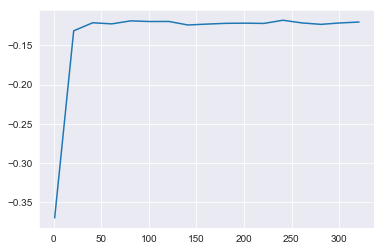

In [133]:
new_result = np.array(new_result)
sns.lineplot(x=new_result[:, 0], y=new_result[:, 1]);

In [136]:
reduce_features = pd.DataFrame(new_result)
reduce_features.sort_values(by=1, ascending=False).head(n=3)

,0,1
22,244,-0.118748
3,206,-0.118965
24,248,-0.119005


In [135]:
new_result = []
for n_features in range(200, 250, 2):
    print(n_features)
    new_features = feature_importances(n_features)
    X_new = X.loc[:, new_features]
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42, shuffle=True)
    xgboost_score = cross_val_score(estimator=xgboost_opt, X=X_train, y=y_train, scoring=rmsle, cv=5)
    new_result.append([n_features, np.mean(xgboost_score)])

200
202
204
206
208
210
212
214
216
218
220
222
224
226
228
230
232
234
236
238
240
242
244
246
248


In [137]:
reduce_features = pd.DataFrame(new_result)
reduce_features.sort_values(by=1, ascending=False).head(n=3)

,0,1
22,244,-0.118748
3,206,-0.118965
24,248,-0.119005


In [140]:
# xgboost_stack

n_features_ker_ridge_stack = 244 
f_impo = feature_importances(n_features_ker_ridge_stack)
data_for_answer = X.loc[:, f_impo]
data_test_new = data_test.loc[:, f_impo]
print('New train shape: ', data_for_answer.shape)
print('New test shape: ', data_test_new.shape)
X_train, X_test, y_train, y_test = train_test_split(data_for_answer, y, test_size=0.2, random_state=42, shuffle=True)

xgboost_opt = XGBRegressor(
     learning_rate = 0.1 / 7, 
     n_estimators = 130 * 7, 
     max_depth = 4, 
     min_child_weight = 1, 
     gamma = 0, 
     subsample = 0.6, 
     colsample_bytree = 0.6,
     reg_alpha = 1e-3,
     reg_lambda = 1.5,
     n_jobs = -1,
     scale_pos_weight = 1,
     random_state=42)
xgboost_score = cross_val_score(estimator=xgboost_opt, X=X_train, y=y_train, scoring=rmsle, cv=5)
print('CV-results: {}'.format(xgboost_score))
print('Mean: {}'.format(np.mean(xgboost_score)))
xgboost_opt.fit(X_train, y_train)
print('Accuracy_test: ', RMSLE(xgboost_opt.predict(X_test), y_test))
print('Accuracy_train: ', RMSLE(xgboost_opt.predict(X_train), y_train))

New train shape:  (1448, 244)
New test shape:  (1459, 244)
CV-results: [-0.10756794 -0.12239583 -0.12051636 -0.10908709 -0.12284451]
Mean: -0.11648234598515166
Accuracy_test:  0.12927572631157971
Accuracy_train:  0.05845277532045836


In [139]:
n_features_ker_ridge_stack = 244 
f_impo = feature_importances(n_features_ker_ridge_stack)
data_for_answer = X.loc[:, f_impo]
data_test_new = data_test.loc[:, f_impo]
print('New train shape: ', data_for_answer.shape)
print('New test shape: ', data_test_new.shape)
X_train, X_test, y_train, y_test = train_test_split(data_for_answer, y, test_size=0.2, random_state=42, shuffle=True)
for i in range(1, 10):
    print('--------------------------------------')
    print(i)
    xgboost_opt = XGBRegressor(
         learning_rate = 0.1 / i, 
         n_estimators = 130 * i, 
         max_depth = 4, 
         min_child_weight = 1, 
         gamma = 0, 
         subsample = 0.6, 
         colsample_bytree = 0.6,
         reg_alpha = 1e-3,
         reg_lambda = 1.5,
         n_jobs = -1,
         scale_pos_weight = 1,
         random_state=42)
    xgboost_score = cross_val_score(estimator=xgboost_opt, X=X_train, y=y_train, scoring=rmsle, cv=5)
    print('CV-results: {}'.format(xgboost_score))
    print('Mean: {}'.format(np.mean(xgboost_score)))
#     xgboost_opt.fit(X_train, y_train)
#     print('Accuracy_test: ', RMSLE(xgboost_opt.predict(X_test), y_test))
#     print('Accuracy_train: ', RMSLE(xgboost_opt.predict(X_train), y_train))

New train shape:  (1448, 244)
New test shape:  (1459, 244)
--------------------------------------
1
CV-results: [-0.11430713 -0.12562471 -0.122868   -0.11201214 -0.11892799]
Mean: -0.11874799196243331
--------------------------------------
2
CV-results: [-0.10877917 -0.1238297  -0.12389026 -0.11133921 -0.12124204]
Mean: -0.11781607793516051
--------------------------------------
3
CV-results: [-0.10952169 -0.12122193 -0.12133188 -0.11167686 -0.11790274]
Mean: -0.11633102111023075
--------------------------------------
4
CV-results: [-0.10899981 -0.12072394 -0.12228317 -0.10888006 -0.12309731]
Mean: -0.11679686097464734
--------------------------------------
5
CV-results: [-0.10734977 -0.12137475 -0.12299944 -0.11151728 -0.12089948]
Mean: -0.1168281437770097
--------------------------------------
6
CV-results: [-0.10625526 -0.12380617 -0.12180654 -0.10883615 -0.12234365]
Mean: -0.11660955262669233
--------------------------------------
7
CV-results: [-0.10756794 -0.12239583 -0.12051636 

# XGBRegressor

In [54]:
def feature_importances(n_features_return):    
    model = XGBRegressor()
    model.fit(X, y)
    feature_importance = pd.DataFrame(data=model.feature_importances_, index=X.columns, columns=['Importance'])
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(15,8))
    sns.barplot(x=feature_importance.iloc[:n_features_return, :].index, y='Importance', 
                data=feature_importance.iloc[:n_features_return, :], color='gray', orient='v')
    plt.title('Feature importance')
    plt.tick_params(rotation=90)
    return feature_importance.index[:n_features_return]

In [57]:
X_new = X.loc[:, f_impo]

In [58]:
f_impo

Index(['OverallCond', 'x0 x1', 'x1 x3', 'LotFrontage', 'BsmtExposure', 'x0 x3',
       'x3 x4', 'TotalBathrooms', 'x0 x9', 'x8 x9', 'x1 x2', 'x3 x7', 'x1 x5',
       'Neighborhood_Crawfor', 'x2 x3', 'x0 x8', 'x0 x4', 'x0 x5', 'BsmtQual',
       'Exterior1st_BrkFace', 'Neighborhood_StoneBr', 'ScreenPorch', 'x1 x4',
       'LotArea_7', 'x7 x8', 'SaleType_New', 'LotArea_0', 'x1 x7',
       'Diff2ndCondition_Flag', 'x9^2', 'x5 x7', 'SaleCondition_Abnorml',
       'x8^2', 'KitchenQual', 'MSZoning_C (all)', 'MoSold_2', 'x0 x7', 'x1^2',
       'BsmtFinType1_GLQ', 'x2 x5', 'FireplaceQu', 'Functional_Typ',
       'BsmtUnfSF_0', 'LotConfig_CulDSac', 'x3 x6', 'BsmtFinType1_Unf',
       'BsmtFinSF1_0', 'x6 x9', 'x5^2', 'OverallQual', 'x1 x8',
       'Neighborhood_CollgCr', 'Neighborhood_ClearCr', 'x0 x6', 'x2 x9',
       'x0 x2', 'HeatingQC', 'KitchenAbvGr', '2ndFlrSF_1',
       'GarageType_CarPort', 'x4 x7', 'x4 x8', 'GarageType_Attchd',
       'BldgType_1Fam', 'Fireplaces', 'CentralAir', 'x6 x8'

In [ ]:
data_test_new = data_test.loc[:, f_impo]

In [ ]:
X_new.shape

In [ ]:
data_test_new.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
xgboost_opt = XGBRegressor(
     learning_rate = 0.1 / 9, 
     n_estimators = 130 * 9, 
     max_depth = 4, 
     min_child_weight = 3, 
     gamma = 1, 
     subsample = 0.6, 
     colsample_bytree = 0.6,
     reg_alpha = 0.5,
     reg_lambda = 0.99,
     n_jobs = -1,
     scale_pos_weight = 1,
     random_state=42)
xgboost_opt.fit(X_train, y_train)

In [ ]:
print('Accuracy_test: ', RMSLE(xgboost_opt.predict(X_test), y_test))
print('Accuracy_train: ', RMSLE(xgboost_opt.predict(X_train), y_train))

In [ ]:
sns.scatterplot(x=xgboost_opt.predict(X_test), y=y_test)
sns.lineplot(np.linspace(50000, 450000, 100), np.linspace(50000, 450000, 100))

# PCA

In [ ]:
xgboost_est = XGBRegressor(random_state=42)
xgboost_score = cross_val_score(estimator=xgboost_est, X=X_train, y=y_train, scoring=rmsle, cv=3)
print('CV-results: {}'.format(xgboost_score))
print('Mean: {}'.format(np.mean(xgboost_score)))

In [ ]:
def pca_reduction(start, finish, step, estimator, est_name): 
    result = []
    for i in range(start, finish, step):
        #print(i)
        pca = PCA(n_components=i, random_state=42)
        est = clone(estimator) 
        X_new = pca.fit_transform(X_train)
        score = cross_val_score(estimator=est, X=X_new, y=y_train, scoring=rmsle, cv=3)
        result.append([i, np.mean(score)])
    sns.lineplot(x=np.array(result)[:, 0], y=np.array(result)[:, 1])
    plt.title('PCA for {}'.format(est_name))
    plt.xlabel('Number of components')
    plt.ylabel('CV-quality')
    plt.show()

In [ ]:
for name, reg in regressors.items():
    pca_reduction(10, 331, 30, reg, est_name=name)

In [ ]:
pca_list = [300, 130, 150, 250, 40, 50, 40, 50]
reg_index = ['Ridge', 'Lasso', 'Elastic', 'Bayesian', 'RandForest', 'GradBoost', 'LassoLars', 'XGBoost']

pca_components = {pair[0] : pair[1] for pair in zip(reg_index, pca_list)}

In [ ]:
pca_quality = pd.DataFrame(index=regressors.keys(), columns=['Quality'])
for name, reg in regressors.items():
    new_reg = clone(reg)
    pca = PCA(n_components=pca_components[name])
    pca.fit(X_train)
    X_new = pca.fit_transform(X_train)
    score = cross_val_score(estimator=new_reg, X=X_new, y=y_train, scoring=rmsle, cv=5)
    pca_quality.loc[name, 'Quality'] = np.mean(score)

In [ ]:
pca_quality

In [ ]:
quality

In [ ]:
np.mean(pca_quality)

# Feature importances

In [59]:
def feature_importances(n_features_return, plot_flag=False):    
    model = XGBRegressor()
    model.fit(X, y)
    feature_importance = pd.DataFrame(data=model.feature_importances_, index=X.columns, columns=['Importance'])
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    
    if plot_flag:
        plt.figure(figsize=(15,8))
        sns.barplot(x=feature_importance.iloc[:n_features_return, :].index, y='Importance', 
                    data=feature_importance.iloc[:n_features_return, :], color='gray', orient='v')
        plt.title('Feature importance')
        plt.tick_params(rotation=90)
    return feature_importance.index[:n_features_return]

In [ ]:
result = []
for n_features in range(1, 341, 20):
    print(n_features)
    new_features = feature_importances(n_features)
    X_new = X.loc[:, new_features]
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42, shuffle=True)
    
    xgboost_opt = XGBRegressor(
     learning_rate = 0.1, 
     n_estimators = 130, 
     max_depth = 4, 
     min_child_weight = 1, 
     gamma = 0.0001, 
     subsample = 0.6, 
     colsample_bytree = 0.6,
     reg_alpha = 0.01,
     reg_lambda = 0.99,
     n_jobs = -1,
     scale_pos_weight = 1,
     random_state=42)
    xgboost_score = cross_val_score(estimator=xgboost_opt, X=X_train, y=y_train, scoring=rmsle, cv=5)
    result.append([n_features, np.mean(xgboost_score)])

In [ ]:
result = np.array(result)
sns.lineplot(x=result[:, 0], y=result[:, 1]);

# Kernel Ridge

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [61]:
# laplacian exponential chi2
#  sigmoid
grid_params = [
#  {'kernel': ['laplacian'],
#     'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 250],
#     'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 250]
#  },
#  {'kernel': ['rbf'],
#   'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 250],
#   'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 250]
#  },
 
 {'kernel': ['poly'],
   'degree': [2, 3, 4, 5, 6, 7],
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1],
    'gamma': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    'coef0': [0.1, 0.5, 1, 5, 10]
 }
]
kernel_ridge_reg = KernelRidge()
grid_search = GridSearchCV(estimator=kernel_ridge_reg, param_grid=grid_params, scoring='neg_mean_squared_error', 
                           cv=5)
grid_search.fit(X=X_train, y=y_train)
grid_search.best_params_, grid_search.best_score_

({'alpha': 0.1, 'coef0': 1, 'degree': 5, 'gamma': 0.001, 'kernel': 'poly'},
 -408713201.7902388)

In [62]:
grid_search.best_estimator_

KernelRidge(alpha=0.1, coef0=1, degree=5, gamma=0.001, kernel='poly',
      kernel_params=None)

In [63]:
ker_ridge_est_stack = KernelRidge(alpha=0.1, coef0=1, degree=5, gamma=0.001, kernel='poly', kernel_params=None)
ker_ridge_est_stack.fit(X_train, y_train)
print('Accuracy_test: ', RMSLE(ker_ridge_est_stack.predict(X_test), y_test))
print('Accuracy_train: ', RMSLE(ker_ridge_est_stack.predict(X_train), y_train))

Accuracy_test:  0.12786833260548353
Accuracy_train:  0.0731204172412442


In [65]:
new_result = []
for n_features in range(1, 341, 20):
    print(n_features)
    new_features = feature_importances(n_features)
    X_new = X.loc[:, new_features]
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42, shuffle=True)
    kernel_ridge_score = cross_val_score(estimator=ker_ridge_est_stack, X=X_train, y=y_train, scoring=rmsle, cv=5)
    new_result.append([n_features, np.mean(kernel_ridge_score)])

1
21
41
61
81
101
121
141
161
181
201
221
241
261
281
301
321


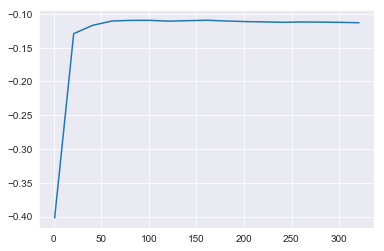

In [66]:
new_result = np.array(new_result)
sns.lineplot(x=new_result[:, 0], y=new_result[:, 1]);

In [67]:
reduce_features = pd.DataFrame(new_result)
reduce_features.sort_values(by=1, ascending=False)

,0,1
8,161.0,-0.109335
5,101.0,-0.109481
4,81.0,-0.109528
7,141.0,-0.109968
9,181.0,-0.110417
3,61.0,-0.110509
6,121.0,-0.110699
10,201.0,-0.111291
11,221.0,-0.111789
13,261.0,-0.111911


In [68]:
new_result = []
for n_features in range(140, 155, 1):
    print(n_features)
    new_features = feature_importances(n_features)
    X_new = X.loc[:, new_features]
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42, shuffle=True)
    kernel_ridge_score = cross_val_score(estimator=ker_ridge_est_stack, X=X_train, y=y_train, scoring=rmsle, cv=5)
    new_result.append([n_features, np.mean(kernel_ridge_score)])

140
141
142
143
144
145
146
147
148
149
150
151
152
153
154


In [69]:
reduce_features = pd.DataFrame(new_result)
reduce_features.sort_values(by=1, ascending=False)

,0,1
14,154,-0.109131
12,152,-0.109238
13,153,-0.109258
11,151,-0.109286
7,147,-0.109333
8,148,-0.109347
9,149,-0.109351
10,150,-0.109352
6,146,-0.109535
5,145,-0.109611


In [82]:
# ker_ridge_stack

n_features_ker_ridge_stack = 154 
f_impo = feature_importances(n_features_ker_ridge_stack)
data_for_answer = X.loc[:, f_impo]
data_test_new = data_test.loc[:, f_impo]
print('New train shape: ', data_for_answer.shape)
print('New test shape: ', data_test_new.shape)
X_train, X_test, y_train, y_test = train_test_split(data_for_answer, y, test_size=0.2, random_state=42, shuffle=True)
ker_ridge_est_stack = KernelRidge(alpha=0.1, coef0=1, degree=5, gamma=0.001, kernel='poly', kernel_params=None)
ker_ridge_score = cross_val_score(estimator=ker_ridge_est_stack, X=X_train, y=y_train, scoring=rmsle, cv=5)
print('CV-results: {}'.format(ker_ridge_score))
print('Mean: {}'.format(np.mean(ker_ridge_score)))
ker_ridge_est_stack.fit(X_train, y_train)
print('Accuracy_test: ', RMSLE(ker_ridge_est_stack.predict(X_test), y_test))
print('Accuracy_train: ', RMSLE(ker_ridge_est_stack.predict(X_train), y_train))

New train shape:  (1448, 154)
New test shape:  (1459, 154)
CV-results: [-0.09597719 -0.11473426 -0.11622211 -0.10434091 -0.11438057]
Mean: -0.10913100839270273
Accuracy_test:  0.12665956195783387
Accuracy_train:  0.08573933293581593


In [ ]:
X_train_stack = pd.DataFrame(data=ker_ridge_est.predict(X_train), columns=['Kernel_Ridge'])
X_test_stack = pd.DataFrame(data=ker_ridge_est.predict(X_test), columns=['Kernel_Ridge'])

In [ ]:
to_file = pd.DataFrame()
to_file['Id'] = test_ids
to_file['SalePrice'] = pd.DataFrame(ker_ridge_est.predict(data_test_new))
to_file.to_csv(path_or_buf="answer_kernel_ridge_1.csv", sep=',', header=True, index=False)

In [ ]:
# # Best params for score 0.11605:
# KernelRidge(alpha=0.1, coef0=1, degree=5, gamma=0.001, kernel='poly', kernel_params=None)
# f_impo = feature_importances(154)

# Bayesian Reg

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [85]:
grid_params = {
    'n_iter': [100, 300, 600, 1000],
    'tol': [1e-5, 1e-4, 1e-3, 1e-2],
    'alpha_1': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
    #'alpha_2': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
    #'lambda_1': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
    #'lambda_2': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
}
bayes_reg = BayesianRidge()
grid_search = GridSearchCV(estimator=bayes_reg, param_grid=grid_params, scoring='neg_mean_squared_error', 
                           cv=5)
grid_search.fit(X=X_train, y=y_train)
grid_search.best_params_, grid_search.best_score_

({'alpha_1': 1e-07, 'n_iter': 100, 'tol': 0.01}, -519307069.75953615)

In [86]:
grid_params = {
    #'n_iter': [100, 300, 600, 1000],
    #'tol': [1e-5, 1e-4, 1e-3, 1e-2],
    #'alpha_1': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
    'alpha_2': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
    'lambda_1': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
    'lambda_2': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
}
bayes_reg = grid_search.best_estimator_
grid_search = GridSearchCV(estimator=bayes_reg, param_grid=grid_params, scoring='neg_mean_squared_error', 
                           cv=5)
grid_search.fit(X=X_train, y=y_train)
grid_search.best_params_, grid_search.best_score_

({'alpha_2': 0.001, 'lambda_1': 0.001, 'lambda_2': 1e-07}, -519307017.9018114)

In [87]:
grid_search.best_estimator_

BayesianRidge(alpha_1=1e-07, alpha_2=0.001, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=0.001, lambda_2=1e-07, n_iter=100,
       normalize=False, tol=0.01, verbose=False)

In [88]:
grid_params = {
    'n_iter': [50, 60, 70, 80, 90, 100, 110, 115],
    'tol': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    #'alpha_1': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
#     'alpha_2': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
#     'lambda_1': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
#     'lambda_2': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
}
bayes_reg = BayesianRidge(alpha_1=1e-07, alpha_2=0.001, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=0.001, lambda_2=1e-07, n_iter=100,
       normalize=False, tol=0.01, verbose=False)
grid_search = GridSearchCV(estimator=bayes_reg, param_grid=grid_params, scoring='neg_mean_squared_error', 
                           cv=5)
grid_search.fit(X=X_train, y=y_train)
grid_search.best_params_, grid_search.best_score_

({'n_iter': 50, 'tol': 0.01}, -519307017.9018114)

In [89]:
bayes_reg = BayesianRidge(alpha_1=1e-07, alpha_2=0.001, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=0.001, lambda_2=1e-07, n_iter=100,
       normalize=False, tol=0.01, verbose=False)
bayes_reg.fit(X_train, y_train)
print('Accuracy_test: ', RMSLE(bayes_reg.predict(X_test), y_test))
print('Accuracy_train: ', RMSLE(bayes_reg.predict(X_train), y_train))

Accuracy_test:  0.14662611878636905
Accuracy_train:  0.10425858894780009


In [91]:
new_result = []
for n_features in range(1, 341, 20):
    print(n_features)
    new_features = feature_importances(n_features)
    X_new = X.loc[:, new_features]
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42, shuffle=True)
    bayes_reg_score = cross_val_score(estimator=bayes_reg, X=X_train, y=y_train, scoring=rmsle, cv=5)
    new_result.append([n_features, np.mean(bayes_reg_score)])

1
21
41
61
81
101
121
141
161
181
201
221
241
261
281
301
321


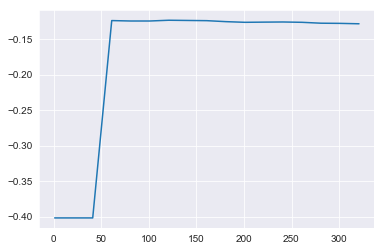

In [92]:
new_result = np.array(new_result)
sns.lineplot(x=new_result[:, 0], y=new_result[:, 1]);

In [93]:
reduce_features = pd.DataFrame(new_result)
reduce_features.sort_values(by=1, ascending=False)

,0,1
6,121.0,-0.123361
7,141.0,-0.123661
3,61.0,-0.123833
8,161.0,-0.123960
5,101.0,-0.124427
4,81.0,-0.124432
9,181.0,-0.125333
12,241.0,-0.125816
11,221.0,-0.126016
13,261.0,-0.126276


In [94]:
new_result = []
for n_features in range(100, 141, 2):
    print(n_features)
    new_features = feature_importances(n_features)
    X_new = X.loc[:, new_features]
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42, shuffle=True)
    bayes_reg_score = cross_val_score(estimator=bayes_reg, X=X_train, y=y_train, scoring=rmsle, cv=5)
    new_result.append([n_features, np.mean(bayes_reg_score)])

100
102
104
106
108
110
112
114
116
118
120
122
124
126
128
130
132
134
136
138
140


In [95]:
reduce_features = pd.DataFrame(new_result)
reduce_features.sort_values(by=1, ascending=False)

,0,1
9,118,-0.123185
10,120,-0.123269
12,124,-0.123685
20,140,-0.123709
11,122,-0.123726
15,130,-0.123781
8,116,-0.123800
14,128,-0.123808
19,138,-0.123942
17,134,-0.124056


In [98]:
# bay_stack

n_features_bay_stack = 118
f_impo = feature_importances(n_features_bay_stack)
data_for_answer = X.loc[:, f_impo]
data_test_new = data_test.loc[:, f_impo]
print('New train shape: ', data_for_answer.shape)
print('New test shape: ', data_test_new.shape)
X_train, X_test, y_train, y_test = train_test_split(data_for_answer, y, test_size=0.2, random_state=42, shuffle=True)
bay_est_stack = BayesianRidge(alpha_1=1e-07, alpha_2=0.001, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=0.001, lambda_2=1e-07, n_iter=100,
       normalize=False, tol=0.01, verbose=False)

bay_score = cross_val_score(estimator=bay_est_stack, X=X_train, y=y_train, scoring=rmsle, cv=5)
print('CV-results: {}'.format(bay_score))
print('Mean: {}'.format(np.mean(bay_score)))
bay_est_stack.fit(X_train, y_train)
print('Accuracy_test: ', RMSLE(bay_est_stack.predict(X_test), y_test))
print('Accuracy_train: ', RMSLE(bay_est_stack.predict(X_train), y_train))

New train shape:  (1448, 118)
New test shape:  (1459, 118)
CV-results: [-0.10656333 -0.13324361 -0.14140763 -0.1152221  -0.11948774]
Mean: -0.12318488108787981
Accuracy_test:  0.14111867433828604
Accuracy_train:  0.11067276310260521


In [100]:
# np.log

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [102]:
grid_params = {
    'n_iter': [100, 300, 600, 1000],
    'tol': [1e-5, 1e-4, 1e-3, 1e-2],
    'alpha_1': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
    #'alpha_2': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
    #'lambda_1': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
    #'lambda_2': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
}
bayes_reg = BayesianRidge()
grid_search = GridSearchCV(estimator=bayes_reg, param_grid=grid_params, scoring='neg_mean_squared_error', 
                           cv=5)
grid_search.fit(X=X_train, y=np.log1p(y_train))
grid_search.best_params_, grid_search.best_score_

({'alpha_1': 1e-07, 'n_iter': 100, 'tol': 0.01}, -0.012520858873446982)

In [103]:
grid_params = {
    #'n_iter': [100, 300, 600, 1000],
    #'tol': [1e-5, 1e-4, 1e-3, 1e-2],
    #'alpha_1': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
    'alpha_2': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
    'lambda_1': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
    'lambda_2': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
}
bayes_reg = grid_search.best_estimator_
grid_search = GridSearchCV(estimator=bayes_reg, param_grid=grid_params, scoring='neg_mean_squared_error', 
                           cv=5)
grid_search.fit(X=X_train, y=np.log1p(y_train))
grid_search.best_params_, grid_search.best_score_

({'alpha_2': 0.001, 'lambda_1': 0.001, 'lambda_2': 1e-07},
 -0.012520841934909807)

In [104]:
grid_search.best_estimator_

BayesianRidge(alpha_1=1e-07, alpha_2=0.001, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=0.001, lambda_2=1e-07, n_iter=100,
       normalize=False, tol=0.01, verbose=False)

In [105]:
bay_log_est = BayesianRidge(alpha_1=1e-07, alpha_2=0.001, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=0.001, lambda_2=1e-07, n_iter=100,
       normalize=False, tol=0.01, verbose=False)

In [106]:
bay_log_est.fit(X_train, np.log1p(y_train))
print('Accuracy_test: ', RMSLE(np.expm1(bayes_reg.predict(X_test)), y_test))
print('Accuracy_train: ', RMSLE(np.expm1(bayes_reg.predict(X_train)), y_train))

Accuracy_test:  0.12900741305693003
Accuracy_train:  0.09021342826683848


In [107]:
new_result = []
for n_features in range(1, 341, 20):
    print(n_features)
    new_features = feature_importances(n_features)
    X_new = X.loc[:, new_features]
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42, shuffle=True)
    bayes_reg_score = cross_val_score(estimator=bay_log_est, X=X_train, y=np.log1p(y_train), scoring=rmsle, cv=5)
    new_result.append([n_features, np.mean(bayes_reg_score)])

1
21
41
61
81
101
121
141
161
181
201
221
241
261
281
301
321


In [109]:
reduce_features = pd.DataFrame(new_result)
reduce_features.sort_values(by=1, ascending=False).head(n=3)

,0,1
4,81,-0.008346
3,61,-0.008366
5,101,-0.008411
7,141,-0.008412
6,121,-0.008414
8,161,-0.008414
9,181,-0.008474
10,201,-0.008545
11,221,-0.008550
12,241,-0.008563


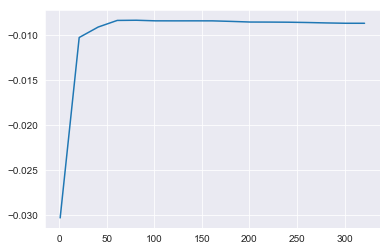

In [110]:
new_result = np.array(new_result)
sns.lineplot(x=new_result[:, 0], y=new_result[:, 1]);

In [111]:
new_result = []
for n_features in range(50, 100, 2):
    print(n_features)
    new_features = feature_importances(n_features)
    X_new = X.loc[:, new_features]
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42, shuffle=True)
    bayes_reg_score = cross_val_score(estimator=bay_log_est, X=X_train, y=np.log1p(y_train), scoring=rmsle, cv=5)
    new_result.append([n_features, np.mean(bayes_reg_score)])

50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98


In [112]:
reduce_features = pd.DataFrame(new_result)
reduce_features.sort_values(by=1, ascending=False).head(n=3)

,0,1
11,72,-0.008297
14,78,-0.008300
10,70,-0.008307
12,74,-0.008313
13,76,-0.008319
4,58,-0.008327
15,80,-0.008338
16,82,-0.008347
5,60,-0.008351
9,68,-0.008363


In [114]:
# bay_stack log

n_features_bay_stack = 72
f_impo = feature_importances(n_features_bay_stack)
data_for_answer = X.loc[:, f_impo]
data_test_new = data_test.loc[:, f_impo]
print('New train shape: ', data_for_answer.shape)
print('New test shape: ', data_test_new.shape)
X_train, X_test, y_train, y_test = train_test_split(data_for_answer, y, test_size=0.2, random_state=42, shuffle=True)
bay_log_est = BayesianRidge(alpha_1=1e-07, alpha_2=0.001, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=0.001, lambda_2=1e-07, n_iter=100,
       normalize=False, tol=0.01, verbose=False)

bay_score = cross_val_score(estimator=bay_log_est, X=X_train, y=np.log1p(y_train), scoring=rmsle, cv=5)
print('CV-results: {}'.format(bay_score))
print('Mean: {}'.format(np.mean(bay_score)))
bay_log_est.fit(X_train, np.log1p(y_train))
print('Accuracy_test: ', RMSLE(np.expm1(bay_log_est.predict(X_test)), y_test))
print('Accuracy_train: ', RMSLE(np.expm1(bay_log_est.predict(X_train)), y_train))

New train shape:  (1448, 72)
New test shape:  (1459, 72)
CV-results: [-0.00730669 -0.00842233 -0.00919485 -0.00804321 -0.00851966]
Mean: -0.00829734680296722
Accuracy_test:  0.12881373651670427
Accuracy_train:  0.09820961229017051


## Stacking

In [376]:
stacked_features_train = pd.DataFrame(index=X_train.index, columns=['Xgboost', 'BayesianReg', 'KernelRidge'])
stacked_features_test = pd.DataFrame(index=X_test.index, columns=['Xgboost', 'BayesianReg', 'KernelRidge'])
stacked_features_answer = pd.DataFrame(index=data_test_new.index, columns=['Xgboost', 'BayesianReg', 'KernelRidge'])

In [377]:
# xgboost_stack

n_features_ker_ridge_stack = 244 
f_impo = feature_importances(n_features_ker_ridge_stack)
data_for_answer = X.loc[:, f_impo]
data_test_new = data_test.loc[:, f_impo]
print('New train shape: ', data_for_answer.shape)
print('New test shape: ', data_test_new.shape)
X_train, X_test, y_train, y_test = train_test_split(data_for_answer, y, test_size=0.2, random_state=42, shuffle=True)

xgboost_opt = XGBRegressor(
     learning_rate = 0.1 / 7, 
     n_estimators = 130 * 7, 
     max_depth = 4, 
     min_child_weight = 1, 
     gamma = 0, 
     subsample = 0.6, 
     colsample_bytree = 0.6,
     reg_alpha = 1e-3,
     reg_lambda = 1.5,
     n_jobs = -1,
     scale_pos_weight = 1,
     random_state=42)
xgboost_opt.fit(X_train, y_train)
print('Accuracy_test: ', RMSLE(xgboost_opt.predict(X_test), y_test))
print('Accuracy_train: ', RMSLE(xgboost_opt.predict(X_train), y_train))

New train shape:  (1448, 244)
New test shape:  (1459, 244)
Accuracy_test:  0.12927572631157971
Accuracy_train:  0.05845277532045836


In [378]:
stacked_features_train['Xgboost'] = xgboost_opt.predict(X_train)
stacked_features_test['Xgboost'] = xgboost_opt.predict(X_test)
stacked_features_answer['Xgboost'] = xgboost_opt.predict(data_test_new)
print(stacked_features_train.head())
print(stacked_features_test.head())
print(stacked_features_answer.head())

            Xgboost BayesianReg KernelRidge
480   333295.000000         NaN         NaN
1441  125802.515625         NaN         NaN
382   208843.843750         NaN         NaN
1097  171084.828125         NaN         NaN
1133  104422.351562         NaN         NaN
            Xgboost BayesianReg KernelRidge
1029  248771.109375         NaN         NaN
383    86658.335938         NaN         NaN
849   201144.187500         NaN         NaN
429   184013.796875         NaN         NaN
194   122650.718750         NaN         NaN
            Xgboost BayesianReg KernelRidge
1456  120296.835938         NaN         NaN
1457  157471.265625         NaN         NaN
1458  179148.921875         NaN         NaN
1459  193358.171875         NaN         NaN
1460  184363.359375         NaN         NaN


In [379]:
# bay_stack log

n_features_bay_stack = 72
f_impo = feature_importances(n_features_bay_stack)
data_for_answer = X.loc[:, f_impo]
data_test_new = data_test.loc[:, f_impo]
print('New train shape: ', data_for_answer.shape)
print('New test shape: ', data_test_new.shape)
X_train, X_test, y_train, y_test = train_test_split(data_for_answer, y, test_size=0.2, random_state=42, shuffle=True)
bay_log_est = BayesianRidge(alpha_1=1e-07, alpha_2=0.001, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=0.001, lambda_2=1e-07, n_iter=100,
       normalize=False, tol=0.01, verbose=False)

bay_log_est.fit(X_train, np.log1p(y_train))
print('Accuracy_test: ', RMSLE(np.expm1(bay_log_est.predict(X_test)), y_test))
print('Accuracy_train: ', RMSLE(np.expm1(bay_log_est.predict(X_train)), y_train))

New train shape:  (1448, 72)
New test shape:  (1459, 72)
Accuracy_test:  0.12881373651670427
Accuracy_train:  0.09820961229017051


In [380]:
stacked_features_train['BayesianReg'] = np.expm1(bay_log_est.predict(X_train))
stacked_features_test['BayesianReg'] = np.expm1(bay_log_est.predict(X_test))
stacked_features_answer['BayesianReg'] = np.expm1(bay_log_est.predict(data_test_new))
print(stacked_features_train.head())
print(stacked_features_test.head())
print(stacked_features_answer.head())

            Xgboost    BayesianReg KernelRidge
480   333295.000000  341600.819062         NaN
1441  125802.515625  123942.140190         NaN
382   208843.843750  203275.067004         NaN
1097  171084.828125  163776.105854         NaN
1133  104422.351562   99998.081217         NaN
            Xgboost    BayesianReg KernelRidge
1029  248771.109375  232449.693799         NaN
383    86658.335938   84520.900906         NaN
849   201144.187500  190372.227660         NaN
429   184013.796875  192841.366187         NaN
194   122650.718750  121065.691389         NaN
            Xgboost    BayesianReg KernelRidge
1456  120296.835938  117554.606977         NaN
1457  157471.265625  155860.777290         NaN
1458  179148.921875  181606.269788         NaN
1459  193358.171875  195701.917801         NaN
1460  184363.359375  192022.225347         NaN


In [381]:
# ker_ridge_stack

n_features_ker_ridge_stack = 154 
f_impo = feature_importances(n_features_ker_ridge_stack)
data_for_answer = X.loc[:, f_impo]
data_test_new = data_test.loc[:, f_impo]
print('New train shape: ', data_for_answer.shape)
print('New test shape: ', data_test_new.shape)
X_train, X_test, y_train, y_test = train_test_split(data_for_answer, y, test_size=0.2, random_state=42, shuffle=True)

ker_ridge_est_stack = KernelRidge(alpha=0.1, coef0=1, degree=5, gamma=0.001, kernel='poly', kernel_params=None)
ker_ridge_est_stack.fit(X_train, y_train)
print('Accuracy_test: ', RMSLE(ker_ridge_est_stack.predict(X_test), y_test))
print('Accuracy_train: ', RMSLE(ker_ridge_est_stack.predict(X_train), y_train))

New train shape:  (1448, 154)
New test shape:  (1459, 154)
Accuracy_test:  0.12665956195783387
Accuracy_train:  0.08573933293581593


In [382]:
stacked_features_train['KernelRidge'] = ker_ridge_est_stack.predict(X_train)
stacked_features_test['KernelRidge'] = ker_ridge_est_stack.predict(X_test)
stacked_features_answer['KernelRidge'] = ker_ridge_est_stack.predict(data_test_new)
print(stacked_features_train.head())
print(stacked_features_test.head())
print(stacked_features_answer.head())

            Xgboost    BayesianReg    KernelRidge
480   333295.000000  341600.819062  343822.631876
1441  125802.515625  123942.140190  122377.007105
382   208843.843750  203275.067004  203169.596272
1097  171084.828125  163776.105854  169449.424319
1133  104422.351562   99998.081217  108541.757066
            Xgboost    BayesianReg    KernelRidge
1029  248771.109375  232449.693799  217521.424901
383    86658.335938   84520.900906   82085.553225
849   201144.187500  190372.227660  194616.085099
429   184013.796875  192841.366187  197736.337640
194   122650.718750  121065.691389  119534.348182
            Xgboost    BayesianReg    KernelRidge
1456  120296.835938  117554.606977  117612.865450
1457  157471.265625  155860.777290  161420.130451
1458  179148.921875  181606.269788  185352.085164
1459  193358.171875  195701.917801  193052.692229
1460  184363.359375  192022.225347  186580.114398


In [383]:
np.sum(np.sum(stacked_features_train.isna()))
np.sum(np.sum(stacked_features_answer.isna()))
np.sum(np.sum(stacked_features_test.isna()))
print('Stacked train size: ', stacked_features_train.shape)
print('Stacked test size: ', stacked_features_test.shape)
print('Stacked answer size: ', stacked_features_answer.shape)
print(y_train.shape)
print(y_test.shape)

Stacked train size:  (1158, 3)
Stacked test size:  (290, 3)
Stacked answer size:  (1459, 3)
(1158,)
(290,)


In [387]:
meta_model = XGBRegressor(max_depth=4, learning_rate=0.01, n_estimators=500, silent=True)
meta_scores = cross_val_score(estimator=meta_model, X=stacked_features_train, y=y_train, scoring=rmsle, cv=5)
print(meta_scores)
print(np.mean(meta_scores))
meta_model.fit(stacked_features_train, y_train)
RMSLE(meta_model.predict(stacked_features_test), y_test)

[-0.04965021 -0.05999403 -0.06691064 -0.06108052 -0.06019432]
-0.05956594326288611


0.13185052280854048

In [389]:
for i in zip(stacked_features_train, meta_model.feature_importances_):
    print(i)

('Xgboost', 0.75352114)
('BayesianReg', 0.16060251)
('KernelRidge', 0.08587637)


In [ ]:
RMSLE(stacked_features_test), y_test)

In [391]:
test_answ = 0.75352114 * stacked_features_test['Xgboost'] + 0.16060251 * stacked_features_test['BayesianReg'] + 0.08587637 * stacked_features_test['KernelRidge']

In [392]:
RMSLE(test_answ, y_test)

0.1265648843908052

In [393]:
RMSLE(np.mean(stacked_features_answer, axis=1), y_test)

-1

In [395]:
np.mean(stacked_features_answer, axis=1)

1456    118488.102788
1457    158250.724455
1458    182035.758942
1459    194037.593968
1460    187655.233040
1461    173348.481784
1462    175912.198670
1463    163705.926756
1464    194607.968713
1465    120656.802247
1466    195177.444935
1467     94644.384939
1468     96346.017797
1469    151397.044519
1470    116797.549599
1471    372576.179161
1472    247579.433400
1473    273693.729502
1474    287507.814296
1475    503771.058046
1476    327721.063141
1477    205389.714325
1478    174363.294530
1479    160808.868008
1480    176615.376528
1481    194709.127015
1482    351012.836282
1483    244278.417174
1484    203146.367010
1485    221168.536820
            ...      
2885     80880.409528
2886    138080.963870
2887     49189.015139
2888     80409.131660
2889     54329.994587
2890    322904.725736
2891    279938.322221
2892    207544.895812
2893    152173.968753
2894    206342.405311
2895    162881.926061
2896    208806.486308
2897    195011.162851
2898    341103.952536
2899    34

# Again and again answer

In [ ]:
f_impo = feature_importances(100)
data_for_answer = X.loc[:, f_impo]
data_for_answer.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_for_answer, y, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
xgboost_opt = XGBRegressor(
     learning_rate = 0.1 / 9, 
     n_estimators = 130 * 9, 
     max_depth = 4, 
     min_child_weight = 1, 
     gamma = 0.0001, 
     subsample = 0.6, 
     colsample_bytree = 0.6,
     reg_alpha = 0.01,
     reg_lambda = 0.99,
     n_jobs = -1,
     scale_pos_weight = 1,
     random_state=42)
xgboost_score = cross_val_score(estimator=xgboost_opt, X=X_train, y=y_train, scoring=rmsle, cv=5)
print('CV-results: {}'.format(xgboost_score))
print('Mean: {}'.format(np.mean(xgboost_score)))

In [ ]:
xgboost_opt.fit(X_train, y_train)
print('Accuracy_test: ', RMSLE(xgboost_opt.predict(X_test), y_test))
print('Accuracy_train: ', RMSLE(xgboost_opt.predict(X_train), y_train))

In [404]:
test_answ = 0.75352114 * stacked_features_answer['Xgboost'] + 0.16060251 * stacked_features_answer['BayesianReg'] + 0.08587637 * stacked_features_answer['KernelRidge']

In [420]:
to_file = pd.DataFrame()
to_file['Id'] = test_ids
to_file['SalePrice'] = test_answ.values
to_file.to_csv(path_or_buf="answer_linear.csv", sep=',', header=True, index=False)

In [421]:
to_file

,Id,SalePrice
0,1461,119625.941830
1,1462,157551.736579
2,1463,180076.287005
3,1464,193708.352388
4,1465,185783.761805
5,1466,171805.504967
6,1467,174752.312948
7,1468,166044.670676
8,1469,190893.059316
9,1470,119558.857783
